### Advanced Forecast Energy Consumption
In this notebook we are going to do Energy Consumption focusting using the `XGBoost` algorithm. The dataset that we are going to use was obtained on kaggle at this url:

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt/input

In this notebook we are going to cover:

1. Outlier Analisis
2. Time Series Cross Validation
3. Focusing Horizon
4. Lag Features
5. Model Inference
6. Saving and Loadingime series.

### Imports

In the following code cell we are going to import all the packages that we are going to use in this notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

xgb.__version__

'2.1.2'

### Data

For the data we are going to use the `AEP_hourly.csv` file for this task.

In [4]:
dataframe = pd.read_csv('./PJME_hourly.csv')
dataframe = dataframe.set_index('Datetime')
dataframe.index = pd.to_datetime(dataframe.index)
dataframe.head(2)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0


Let's plot the data that we have.

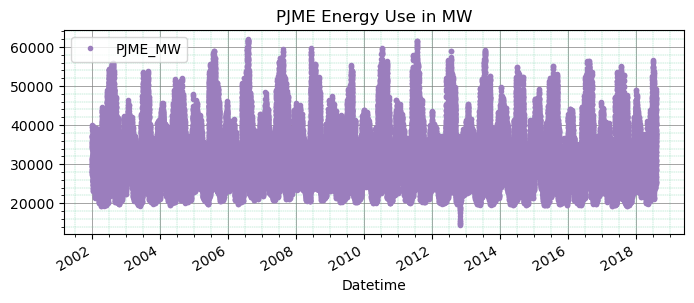

In [6]:
dataframe.plot(style='.', figsize=(8, 3),color="#9B7EBD", title='PJME Energy Use in MW')

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Outlier Analyisis.

We can be able to see that around year `2013` there is an outlier there where most value of this `PJME` values are just a bit bellow 20000 and just slight bellow `60000`.

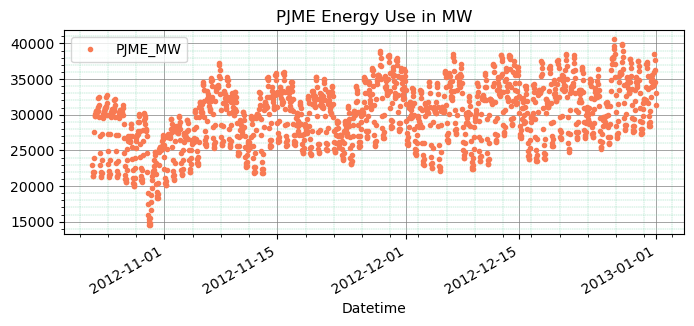

In [8]:
dataframe.loc[(dataframe.index > '23-10-2012') & (dataframe.index < '01-01-2013')].plot(
    style='.', figsize=(8, 3),color="#F87A53", title='PJME Energy Use in MW'
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

We can visually see our outlier ther in around 11 November `2012`. Let's use a histogram to plot the data.

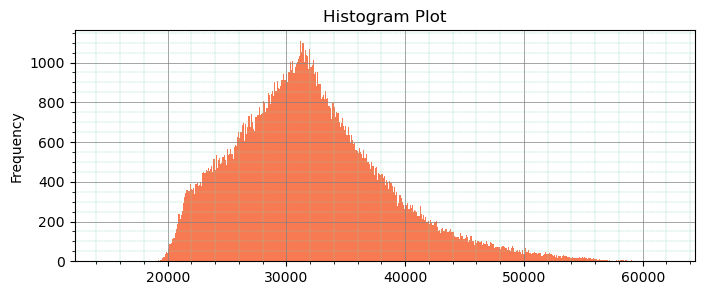

In [10]:
dataframe['PJME_MW'].plot(kind='hist', bins=500, figsize=(8, 3),color="#F87A53", title="Histogram Plot")
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

It can be seen that most of the values are between `20000` and `50000` other values thar are ouside that we can consider them as outliers. Let's plot a distogram plot for the PJME for the dates that we have selected which we saw that there are some outliers values which are between `23-10-2012'` and `01-01-2013`

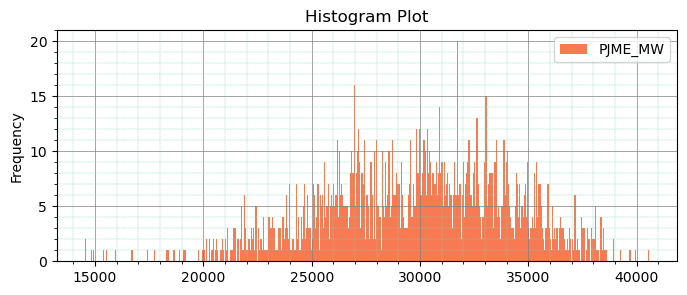

In [12]:
dataframe.loc[(dataframe.index > '23-10-2012') & (dataframe.index < '01-01-2013')].plot(kind='hist',
                                                                                        bins=500, figsize=(8, 3),
                                                                                        color="#F87A53", title="Histogram Plot"
                                                                                       )
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

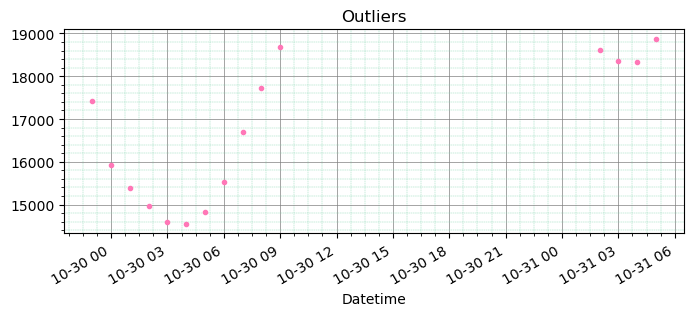

In [13]:
dataframe.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',
          figsize=(8, 3),
          color='#FF77B7',
          title='Outliers')
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to take remove outliers.

In [15]:
dataframe = dataframe.query('PJME_MW > 19_000').copy()

In the previous notebook we split our dataset as follows.

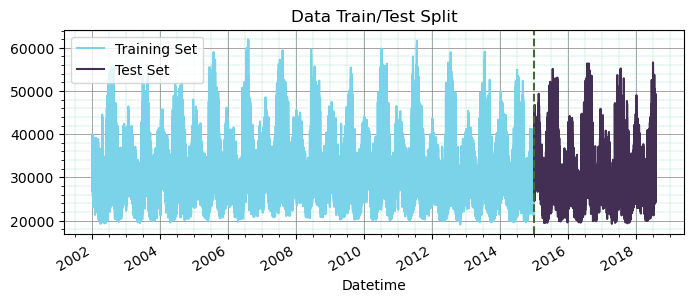

In [17]:
train = dataframe.loc[dataframe.index < '01-01-2015']
test = dataframe.loc[dataframe.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(8, 3))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', color="#7BD3EA")
test.plot(ax=ax, label='Test Set', color="#432E54")
ax.axvline('01-01-2015', color='#47663B', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

This time around we are going to use the [`TimeSeriesSplit`](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) from `sklearn.model_selection`. And avter doing the splits we are going to visualize the data.

### Train and Test Split


In [19]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
dataframe = dataframe.sort_index()
tss

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760)

Now let's plot the splits in our dataframe after using the `tss` split.

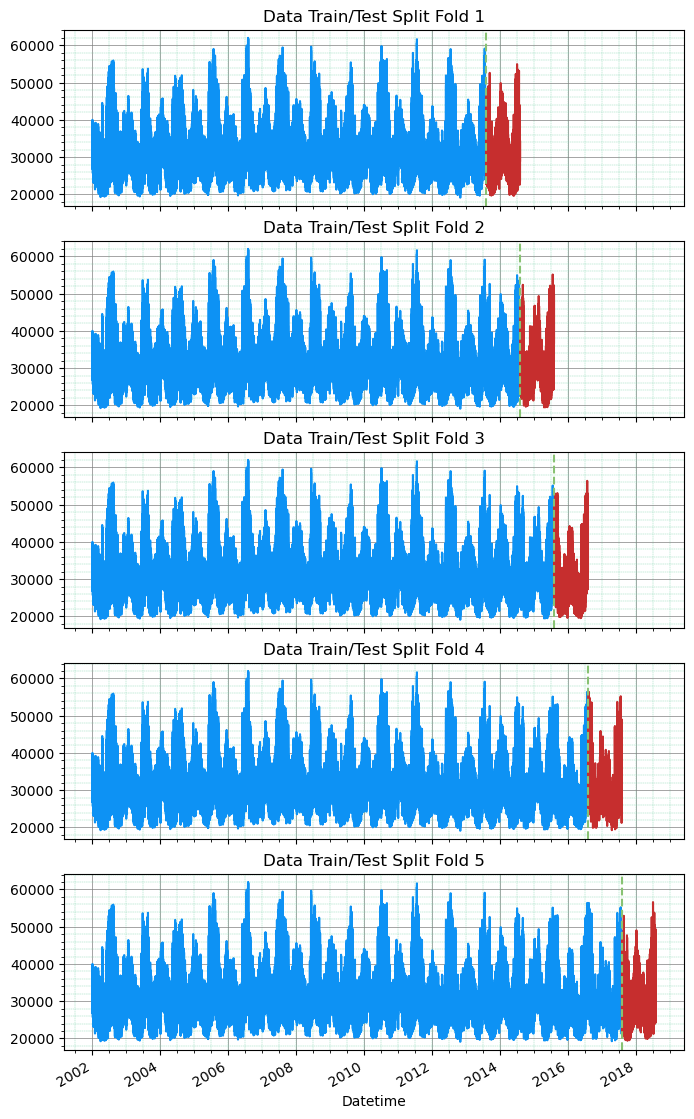

In [21]:
fig, axs = plt.subplots(5, 1, figsize=(8, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(dataframe):
    train = dataframe.iloc[train_idx]
    test = dataframe.iloc[val_idx]
    train['PJME_MW'].plot(
        ax=axs[fold],
        label='Training Set',
        title=f'Data Train/Test Split Fold {fold + 1}',
        color="#0D92F4"
    )
    test['PJME_MW'].plot(
        ax=axs[fold],
        label='Test Set',
        color="#C62E2E"
    )
    axs[fold].axvline(test.index.min(), color='#88C273', ls='--')
    axs[fold].minorticks_on()
    axs[fold].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    axs[fold].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
    fold += 1

plt.show()


### Forecasting Horizon Explained¶

> The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

### Feature Creation
In the following code cell we are going to look at creating features. For that we are going to create a function that will do that called `create_features`.

In [24]:
def create_features(dataframe):
    """
    Create time series features based on time series index.
    """
    dataframe = dataframe.copy()
    dataframe['hour'] = dataframe.index.hour
    dataframe['dayofweek'] = dataframe.index.dayofweek
    dataframe['quarter'] = dataframe.index.quarter
    dataframe['month'] = dataframe.index.month
    dataframe['year'] = dataframe.index.year
    dataframe['dayofyear'] = dataframe.index.dayofyear
    dataframe['dayofmonth'] = dataframe.index.day
    dataframe['weekofyear'] = dataframe.index.isocalendar().week
    return dataframe

dataframe = create_features(dataframe)
dataframe.head(3)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1


### Lag Features

What was the target (x) days in the past.

In [26]:
def add_lags(dataframe):
    target_map = dataframe['PJME_MW'].to_dict()
    dataframe['lag1'] = (dataframe.index - pd.Timedelta('364 days')).map(target_map)
    dataframe['lag2'] = (dataframe.index - pd.Timedelta('728 days')).map(target_map)
    dataframe['lag3'] = (dataframe.index - pd.Timedelta('1092 days')).map(target_map)
    return dataframe

dataframe = add_lags(dataframe)
dataframe.head(3)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN


We can see that lag1 to lag 3 are empty values, This is because there was no data for the previous years. Let's check the new values in our dataframe from the tail that will contain lag features.

In [28]:
dataframe.tail(3)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


### Training and Validation

Next we are going to train our model.

In [30]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
dataframe = dataframe.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(dataframe):
    train = dataframe.iloc[train_idx]
    test = dataframe.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    model = reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


C:\Users\crisp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:15] WARNING: D:\bld\xgboost-split_1730232592996\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[441]	validation_0-rmse:3370.76149	validation_1-rmse:3764.48078
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


C:\Users\crisp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:23] WARNING: D:\bld\xgboost-split_1730232592996\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


C:\Users\crisp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:41] WARNING: D:\bld\xgboost-split_1730232592996\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[411]	validation_0-rmse:3475.26636	validation_1-rmse:3503.65414
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


C:\Users\crisp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:50] WARNING: D:\bld\xgboost-split_1730232592996\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.56538
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.01446
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.23557
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.12690
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.46154
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4052.57120
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


C:\Users\crisp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:13] WARNING: D:\bld\xgboost-split_1730232592996\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[440]	validation_0-rmse:3479.88018	validation_1-rmse:4011.05271


We can check the scores in each fold.

In [32]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3742.5833
Fold scores:[3760.8277187583353, 3420.313091887879, 3478.018038580526, 4052.5712055405547, 4001.186553933809]


We can plot the scores per fold as follows.

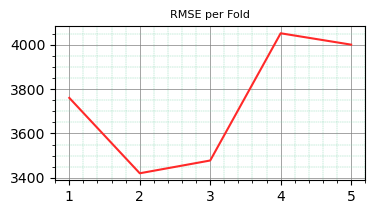

In [34]:
plt.figure(figsize=(4, 2))
plt.plot(
    np.arange(1, len(scores) +1),
    scores, color ="#FF2929"
)
plt.title("RMSE per Fold", fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

We can see that the best model was observed on the begining of fold 2.


### Predicting the Future

First we are going to train the model using all the data.

In [36]:
# Retrain on all data
dataframe = create_features(dataframe)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = dataframe[FEATURES]
y_all = dataframe[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
model = reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100
)

[0]	validation_0-rmse:32403.88991


C:\Users\crisp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:24] WARNING: D:\bld\xgboost-split_1730232592996\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


Let's check what was the maximum date in the dataframe.

In [38]:
dataframe.index.max()

Timestamp('2018-08-03 00:00:00')

Let's create a future dataframe and concatenate it with our previous dataframe so that we can calculate the lag features for the future and we will check the first `5` rows of this datafram.

In [40]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
dataframe['isFuture'] = False
df_and_future = pd.concat([dataframe, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

df_and_future.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False


We are going to get the future features from the dataframe that we have created.

> Note thet the `PJME_MW` is not known here because that what we are going to predict in the future.

In [42]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features.head(2)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True


Let's make some predictions and store them in the `pred` column and then plot them.

In [44]:
future_w_features['pred'] = model.predict(future_w_features[FEATURES])

In [45]:
future_w_features.head(3)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture,pred
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True,30747.998047
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True,28575.041016
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True,27978.013672


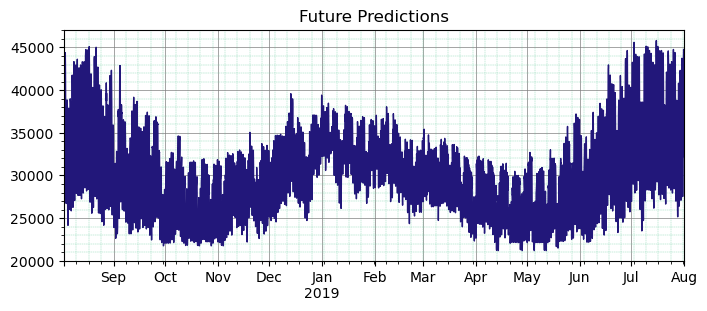

In [46]:
future_w_features['pred'].plot(
    figsize=(8, 3),
    color="#22177A",
   ms=1,
   lw=1,
   title='Future Predictions'
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Saving model

Next we are going to use the `save_model` method on our model to save the model.

In [48]:
model.save_model('model.json')
print("Saved")

Saved


We cal load the model using the `load_model` method and make some predictions using our saved model as follows:

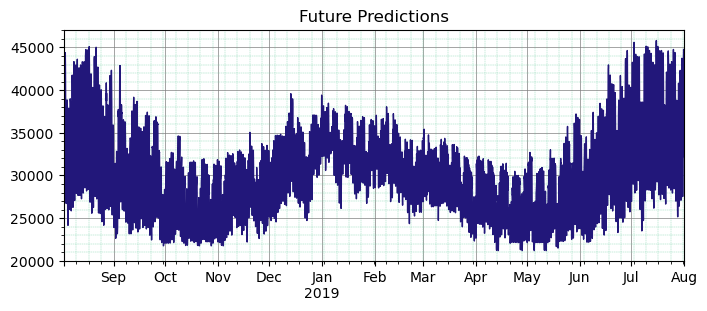

In [50]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])

future_w_features['pred'].plot(
    figsize=(8, 3),
    color="#22177A",
    ms=1,
    lw=1,
    title='Future Predictions'
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Refs.

1. https://xgboost.readthedocs.io/en/stable/install.html#minimal-installation-cpu-only